In [1]:
import json

from wmfdata import charting, mariadb, hive
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata
/usr/lib/python3/dist-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 30] Read-only file system.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
mpl.style.use(charting.mpl_style)

# Data wrangling

Let's grab a two-week sample of events. Note that these logs are a 6.25% sample of all events, so the absolute numbers need to be multiplied by 16 to get the true estimate of events.

Also, the 2010 wikitext editor has [kept sending events to an old schema version](https://phabricator.wikimedia.org/T203621) even after the schema was updated in December 2017, so we'll have to join the two tables. The [update](https://meta.wikimedia.org/w/index.php?title=Schema%3AEdit&type=revision&diff=17541122&oldid=13457736) involved adding `loaded` as a possible value for `event_action` and a corresponding `event_action.loaded.timing` field.

In [8]:
events_175 = mariadb.run("""
select *
from log.Edit_17541122
where timestamp between "20180831" and "20180914"
""", host="logs")

In [9]:
events_134 = mariadb.run("""
select *
from log.Edit_13457736
where timestamp between "20180831" and "20180914"
""", host="logs")

In [30]:
events = pd.concat([events_134, events_175], ignore_index=True, sort=False)

In [31]:
# Shorten the names of the events
el_rename = lambda x: x.replace("event_", "").replace("action.", "").replace(".", "")
events = events.rename(columns=el_rename)

# Parse the user agent attribute, which is a JSON string
parsed_ua = pd.io.json.json_normalize(events["userAgent"].map(json.loads)).add_prefix("ua_")
events = pd.concat([events, parsed_ua], axis=1).drop(["userAgent"], axis=1)

# Make action a categorical variable with a roughly progressive sort order
action_names = ["init", "loaded", "ready", "saveIntent", "saveAttempt", "saveSuccess", "saveFailure", "abort"]
events["action"] = pd.Categorical(events["action"], categories=action_names, ordered=True)

# Sort the events for chronological display.
# If actions have the same timestamp, they'll get sorted by the actions in their custom sort order.
events = events.sort_values(["timestamp", "action"])

# Reset the index, which is a mess because of the concatenation
events = events.reset_index(drop=True)

# Some missing values are represented as `None`, others as `NaN`. Make that consistent.
events = events.fillna(value=np.nan)

In [32]:
# Show the now lovely dataset. Hidden from public output for privacy reasons.
with pd.option_context(
    'display.max_rows', 10, 
    'display.max_columns', None,
    'display.max_colwidth', 500,
):
    display(events)

,id,uuid,timestamp,webHost,wiki,action,abortmechanism,aborttiming,aborttype,initmechanism,inittiming,inittype,readytiming,saveAttempttiming,saveFailuremessage,saveFailuretiming,saveFailuretype,saveIntenttiming,saveSuccesstiming,editingSessionId,editor,integration,mediawikiversion,pageid,pagens,pagerevid,pagetitle,platform,userclass,usereditCount,userid,version,dt,loadedtiming,ua_browser_family,ua_browser_major,ua_browser_minor,ua_device_family,ua_is_bot,ua_is_mediawiki,ua_os_family,ua_os_major,ua_os_minor,ua_wmf_app_version
0,74278574,8d4c8357ad185f9daf135e8eeeeb66f3,20180831000000,ja.wikipedia.org,jawiki,abort,navigate,4267.0,nochange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0e13c75c435e01525e11,visualeditor,page,1.32.0-wmf.19,0,0,0,チェンマイ国立博物館,desktop,IP,0,0,1,NaN,NaN,IE,11,0,Other,False,False,Windows,7,NaN,-
1,146830901,164fee9e0c2f5b84a4f07a486bcb7a00,20180831000002,en.wikipedia.org,enwiki,init,NaN,NaN,NaN,click,NaN,page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c75c70634407e350f3a1060f3481f9b,wikitext,page,1.32.0-wmf.19,7877042,0,840899223,1907 in poetry,desktop,NaN,65,256776,1,NaN,NaN,Firefox,61,0,Other,False,False,Windows,10,NaN,-
2,74278812,38080b004cf95c5da441dae49a47de23,20180831000002,en.wikipedia.org,enwiki,loaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c75c70634407e350f3a1060f3481f9b,wikitext,page,1.32.0-wmf.19,7877042,0,0,1907_in_poetry,desktop,NaN,65,256776,1,NaN,803.0,Firefox,61,0,Other,False,False,Windows,10,NaN,-
3,74278974,cd0ec4a890c959fc89f1a420ac0ba6a7,20180831000002,en.wikipedia.org,enwiki,ready,NaN,NaN,NaN,NaN,NaN,NaN,634.0,NaN,NaN,NaN,NaN,NaN,NaN,0c75c70634407e350f3a1060f3481f9b,wikitext,page,1.32.0-wmf.19,7877042,0,0,1907_in_poetry,desktop,NaN,65,256776,1,NaN,NaN,Firefox,61,0,Other,False,False,Windows,10,NaN,-
4,74278659,487c135a59c85bd495bbb3aca34ea20a,20180831000003,de.wikipedia.org,dewiki,init,NaN,NaN,NaN,click,NaN,section,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0679341e1d93b6cc720e,visualeditor,page,1.32.0-wmf.19,3546,0,179704035,Niedersachsen,other,IP,0,0,1,NaN,NaN,Firefox,61,0,Other,False,False,Windows,10,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501370,76185916,f1de46c443555c7a959f7972ca75aeb8,20180913235957,ja.wikipedia.org,jawiki,abort,navigate,18466.0,nochange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c736d40c71617d0e104,visualeditor,page,1.32.0-wmf.20,0,0,0,星野朝子,desktop,IP,0,0,1,NaN,NaN,Edge,17,17134,Other,False,False,Windows,10,NaN,-
3501371,148427918,2832f828413851f6a3662b93fed0f83e,20180913235958,be.wikipedia.org,bewiki,init,NaN,NaN,NaN,url,NaN,page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0be06b6df57dba54ce9c6e358898b697,wikitext,page,1.32.0-wmf.20,0,0,0,Joachim Granit,desktop,IP,0,0,1,NaN,NaN,Other,NaN,NaN,Other,True,True,Other,NaN,NaN,-
3501372,148427919,1212ebe55f3f5b21a71b01907dba8e94,20180913235959,en.wiktionary.org,enwiktionary,init,NaN,NaN,NaN,click,NaN,section,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0034f90d7762b8b223303cd7d50bd904,wikitext,page,1.32.0-wmf.20,2878862,0,43495431,one and only,desktop,IP,0,0,1,NaN,NaN,Chrome Mobile,67,0,Samsung SM-J327T1,False,False,Android,7,0,-
3501373,76186037,b4b8aecdaca558ed82dc77c40fd9555e,20180913235959,es.wikipedia.org,eswiki,loaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0fe12c5d4fa926320e4563b38ebc3333,wikitext,page,1.32.0-wmf.20,8554741,104,0,Anexo:Bailando_2018,desktop,IP,0,0,1,NaN,3245.0,Chrome,69,0,Other,False,False,Windows,7,NaN,-


We should also aggregate these into events into sessions.

In [ ]:
grouped = events.groupby("editingSessionId", sort=False)

def concat_unique(ser):
    return "-".join(ser.map(str).unique())

def my_aggs(grp):
    res = {}
    
    res["os_family"] = concat_unique(grp["ua_os_family"])
    res["browser_family"] = concat_unique(grp["ua_browser_family"])
    res["userid"] = concat_unique(grp["userid"])
    res["editor"] = concat_unique(grp["editor"])
    res["platform"] = concat_unique(grp["platform"]) 
    res["ve_pct"] = ((grp["editor"] == "visualeditor").sum() / len(grp))
    res["actions"] = "-".join(grp["action"])
    res["editCount"] = grp["usereditCount"].min()
    
    return pd.Series(res)

action_counts = pd.DataFrame(grouped["action"].apply(lambda x: x.value_counts())).unstack()
action_counts.columns = action_counts.columns.droplevel(0)
action_counts = action_counts.add_suffix("_count")

sessions = action_counts.join(grouped.apply(my_aggs))

In [68]:
# Hidden from public output for privacy reasons.
sessions.head()

,init_count,loaded_count,ready_count,saveIntent_count,saveAttempt_count,saveSuccess_count,saveFailure_count,abort_count,actions,browser_family,editCount,editor,os_family,platform,userid,ve_pct
editingSessionId,,,,,,,,,,,,,,,,
0e13c75c435e01525e11,0,0,0,0,0,0,0,1,abort,IE,0,visualeditor,Windows,desktop,0,1.0
0c75c70634407e350f3a1060f3481f9b,1,1,1,0,0,0,0,1,init-loaded-ready-abort,Firefox,65,wikitext,Windows,desktop,256776,0.0
0679341e1d93b6cc720e,1,0,0,0,0,0,0,0,init,Firefox,0,visualeditor,Windows,other,0,1.0
0a4f522f8623d775942a83a6612064b1,0,0,0,0,1,1,0,0,saveAttempt-saveSuccess,Firefox,106748,wikitext,Ubuntu,desktop,3482,0.0
02a730f90b7800771a92d8349051f3ab,0,2,2,0,1,1,0,0,loaded-ready-loaded-ready-saveAttempt-saveSuccess,Chrome,0,wikitext,Windows,desktop,0,0.0


# Overall event counts

There are a number of obvious problems that are obvious right away from looking at the overall event counts:
* Essentially no events of any kind were logged from phone editors.
* Large number of visual editor (VE) `init` events with platform `other`, which seem to be misclassified `desktop` events.
* Large number of 2017 wikitext editor (2017 WTE) `init` and `ready` events with platform `other`, which are probably misclassified `desktop` events.

The 2010 wikitext editor didn't log any `saveIntent` events, but that's intentional, since it doesn't have a corresponding step in the save workflow.

In [36]:
events.pivot_table("id", index="action", columns=["editor", "platform"], aggfunc=len, fill_value=0).sort_index()

editor      visualeditor         wikitext       wikitext-2017      
platform         desktop   other  desktop phone       desktop other
action                                                             
init                3112  108795  1205283    13           763  3493
loaded            103951       0   549706     0          4177     0
ready             103910       0   552674    13          1466  2770
saveIntent         15551       0        0     1          3946     0
saveAttempt        16112       0   195297     0          2766     0
saveSuccess        12777       0   176631     0          2695     0
saveFailure         3479       0    18662     0            93     0
abort              89929       0   321841     4          1465     0

# Phone events
The phone events seem to have stopped in late June or early July 2018.

In [ ]:
phone = mariadb.run("""
select
    left(timestamp, 6) as month,
    sum(event_editor = "wikitext") as wikitext_events,
    sum(event_editor = "visualeditor") as visualeditor_events
from log.Edit_17541122
where
    event_platform = "phone"
group by left(timestamp, 6)
""", host = "logs")

In [38]:
phone

,month,wikitext_events,visualeditor_events
0,201712,2037604.0,28271.0
1,201801,4341238.0,59143.0
2,201802,3897444.0,53763.0
3,201803,4220510.0,59607.0
4,201804,4084998.0,57519.0
5,201805,4263057.0,49500.0
6,201806,4170920.0,61958.0
7,201807,686.0,16.0
8,201808,68.0,0.0
9,201809,61.0,4.0


We thought this was fixed by [T202786](https://phabricator.wikimedia.org/T202786), the fix for which started rolling out on 28 August. However, we haven't seen any events start flowing in since.

In [39]:
mariadb.run("""
select
    left(timestamp, 8) as day,
    sum(event_platform = "phone") as phone_events,
    sum(event_platform = "desktop") as desktop_events
from log.Edit_17541122
where
    timestamp >= "20180828" 
group by left(timestamp, 8)
""", host="logs")

,day,phone_events,desktop_events
0,20180828,0.0,136741.0
1,20180829,0.0,129145.0
2,20180830,2.0,138717.0
3,20180831,0.0,122732.0
4,20180901,0.0,62527.0
5,20180902,0.0,62394.0
6,20180903,0.0,79667.0
7,20180904,0.0,79274.0
8,20180905,10.0,94588.0
9,20180906,2.0,167764.0


There have been a few recent validation errors, but not nearly enough to account for the roughly 500 000 missing events every month. So it seems like the mobile events are just not getting sent.

In [41]:
edit_errors = hive.run("""
select
    date_format(from_unixtime(timestamp), "YYYY-MM") as month,
    count(*) as errors
from event.eventerror
where
    year = 2018 and
    month >= 5 and
    event.schema = "Edit"
group by date_format(from_unixtime(timestamp), "YYYY-MM")
""")

edit_errors.sort_values("month").head()

,month,errors
1,2018-04,3
2,2018-05,5034
3,2018-06,2481
4,2018-07,7251
5,2018-08,3073


If we go back to before the events dropped off, we can also identify any underlying problems in the mobile edit data.

In [42]:
may_phone_r = mariadb.run("""
select *
from log.Edit_17541122
where
    timestamp between "201805" and "201806" and
    event_platform = "phone"
""", host="logs")

In [43]:
# Output hidden for privacy.
may_phone_r.head()

,id,uuid,dt,timestamp,userAgent,webHost,wiki,event_action,event_action.abort.mechanism,event_action.abort.timing,...,event_mediawiki.version,event_page.id,event_page.ns,event_page.revid,event_page.title,event_platform,event_user.class,event_user.editCount,event_user.id,event_version
0,45781438,2c79dab32d765100a3240cd62318c36d,None,20180501000000,None,en.m.wikipedia.org,enwiki,abort,cancel,None,...,1.32.0-wmf.1,23820760,0,837425106,Camille_Paglia,phone,IP,0,0,1
1,45781558,0638ee3300f65965a224c20307fa2c7b,None,20180501000000,None,ja.m.wikipedia.org,jawiki,init,None,None,...,1.32.0-wmf.1,19440,0,68385244,マイケル・J・フォックス,phone,IP,0,0,1
2,45781965,fcc6125953b05351b757a6c4144f575f,None,20180501000000,None,ja.m.wikipedia.org,jawiki,ready,None,None,...,1.32.0-wmf.1,19440,0,68385244,マイケル・J・フォックス,phone,IP,0,0,1
3,45781559,1a3f8f0f12fc50ce893d44fb972b2e6d,None,20180501000001,None,en.m.wikipedia.org,enwiki,init,None,None,...,1.32.0-wmf.1,23820760,0,837425106,Camille_Paglia,phone,IP,0,0,1
4,45781966,24495040e28f5e13b3ae04380e3250b3,None,20180501000001,None,en.m.wikipedia.org,enwiki,ready,None,None,...,1.32.0-wmf.1,23820760,0,837425106,Camille_Paglia,phone,IP,0,0,1


* No `loaded` or `saveFailure` events recorded for mobile VE.
* No `loaded` events recorded for the mobile WTE.
* There are unusually few `abort` events for both mobile editors. On the desktop editors, the combined number of `abort` and `saveAttempt` events roughly match the number of `ready` events, but that isn't the case here. 

In [44]:
may_phone_r.pivot_table("id", index="event_action", columns="event_editor", aggfunc=len, fill_value=0)

event_editor,visualeditor,wikitext
event_action,,
abort,1676,286462
init,14212,1920523
ready,21491,1865475
saveAttempt,4396,57891
saveFailure,0,9632
saveIntent,4601,75538
saveSuccess,3124,47536


# Non-logged fields

A lot of fields have mostly null values. These all seem to be as expected.

In [46]:
null_prop = lambda ser: ser.isnull().sum() / len(ser) 

events.apply(null_prop).sort_values(ascending=False).loc[lambda x: x >= 0.1]

dt                    1.000000
inittiming            1.000000
saveFailuretiming     0.998980
saveSuccesstiming     0.995581
saveFailuremessage    0.994722
saveAttempttiming     0.994608
saveIntenttiming      0.994432
saveFailuretype       0.993650
abortmechanism        0.973897
aborttiming           0.881979
aborttype             0.881978
loadedtiming          0.812121
readytiming           0.811268
ua_os_minor           0.801632
initmechanism         0.622589
inittype              0.622589
userclass             0.331744
dtype: float64

For example, `inittype` and `initmechanism` only apply to `init` events, but are present for all of them.

In [47]:
inits = events.query("action == 'init'")

In [48]:
null_prop(inits["inittype"])

0.0

In [49]:
null_prop(inits["initmechanism"])

0.0

Likewise, the proportion of `ready` events without a `readytiming` value is extremely low.

In [50]:
readies = events.query("action == 'ready'")

In [51]:
readytiming_null_prop = null_prop(readies["readytiming"])
"{:,.5f}%".format(readytiming_null_prop * 100)

'0.00197%'

# Number of events by session

The distribution of events per session is generally as expected, with one exception:

Roughly 3% of sessions have more than 1 `loaded` and `ready` event.

In [52]:
def calc_dist(ser):
    bins = [0, 1, 2, 10, 100, 1000]
    cut_ser = pd.cut(ser, bins, right=False)
    return cut_ser.value_counts(normalize=True).sort_index().apply(
        lambda x:"{:,.2f}%".format(x * 100)
    )

action_names = ["init", "loaded", "ready", "abort", "saveIntent", "saveAttempt", "saveSuccess", "saveFailure"]
dists = [calc_dist(sessions[name + "_count"]) for name in action_names]
pd.concat(dists, axis=1)

,init_count,loaded_count,ready_count,abort_count,saveIntent_count,saveAttempt_count,saveSuccess_count,saveFailure_count
"[0, 1)",3.26%,58.70%,58.49%,70.10%,98.75%,85.04%,86.01%,98.62%
"[1, 2)",96.74%,38.24%,38.43%,29.63%,1.15%,14.44%,13.93%,1.23%
"[2, 10)",0.00%,2.97%,2.98%,0.28%,0.10%,0.52%,0.05%,0.15%
"[10, 100)",0.00%,0.10%,0.10%,0.00%,0.00%,0.00%,0.00%,0.00%
"[100, 1000)",0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


This is the same 3%; the number of `ready` and `loaded` events in a session are extremely well correlated.

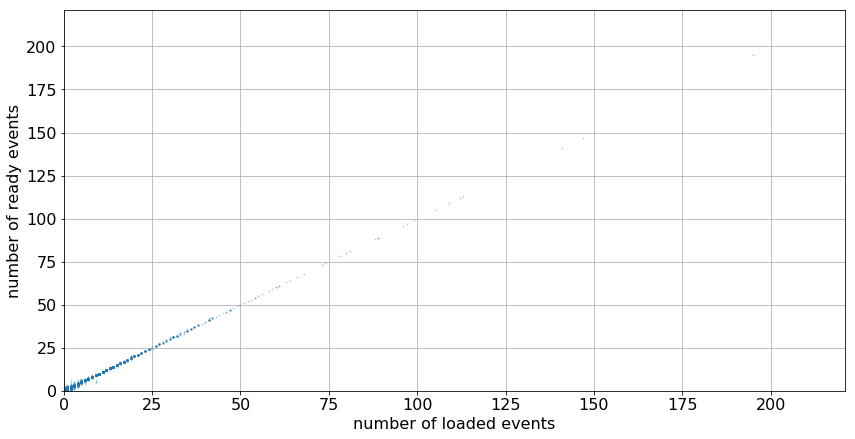

In [53]:
plt.scatter(sessions["loaded_count"], sessions["ready_count"], s=1, alpha=0.25);
plt.xlabel("number of loaded events")
plt.ylabel("number of ready events");

The reason seems to be that sessions frequently feature repeated pairs of `loaded` and `ready` events. 3 of the top 20 session patterns feature at least two `loaded`–`ready` cycles

In [54]:
pd.DataFrame(sessions["actions"].value_counts()).head(20)

,actions
init,709622
init-loaded-ready-abort,341134
init-loaded-ready-saveAttempt-saveSuccess,68489
init-saveAttempt-saveSuccess,52012
init-loaded-ready,35050
init-ready-loaded-abort,27589
init-loaded-ready-loaded-ready-saveAttempt-saveSuccess,11921
init-loaded-ready-saveIntent-saveAttempt-saveSuccess,10802
loaded-ready-abort,10322
init-saveAttempt-saveFailure,10257


# Editor switch sessions
There are very few sessions that involve editor switches, because only switches to or from the 2017 wikitext editor (currently in opt-in beta) are actually recorded within a single session. Switching to or from the 2010 wikitext editor involves a page reload and therefore the initiation of an entirely new session.

In [56]:
sessions["editor"].value_counts()

wikitext                      1245832
visualeditor                   115438
wikitext-2017                    4431
visualeditor-wikitext-2017        121
wikitext-2017-visualeditor        105
Name: editor, dtype: int64

# Writing data

In [69]:
events.to_csv("data/events.tsv", sep="\t", index=False)

In [70]:
sessions.to_csv("data/sessions.tsv", sep="\t", index=False)